**`Important`**: Results from the PyTorch code can be different but similar to the results from the Keras code of the original homework.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In this homework, we'll build a model for predicting if we have an image of a bee or a wasp. For this, we will use the "Bee or Wasp?" dataset that was obtained from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp) and slightly rebuilt.

You can download the dataset for this homework from [here](https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip) or use the commands in this notebook.

In [2]:
# !wget -c https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
# !unzip data.zip 

## Data Preparation

- The dataset contains around 2500 images of bees and around 2100 images of wasps.
- The dataset contains separate folders for training and test sets.



## Model

The architecture of the model required for this section can be found in text form in the homework-file.

In [3]:
import torch
import torch.nn as nn

# Getting some info about the availability of GPU and the version of torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch: ", torch.__version__)
print("Device:", device)

PyTorch:  2.1.1
Device: cuda


In [67]:
class CNN(nn.Module):
    def __init__(
        self, 
        input_dim: int = 3, 
        output_dim: int = 1
    ):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(
                in_channels=input_dim, 
                out_channels=32,
                kernel_size=3,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(175232, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out.squeeze()

In [68]:
# Create instance of CNN-model
cnn_model = CNN().to(device)

In [69]:
cnn_model

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=175232, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [27]:
def accuracy_fn(outputs, labels):
    pred = torch.round(outputs)
    correc_pred = (pred == labels).sum().float()
    acc = correc_pred / len(outputs)
    return acc

def train(model, optimizer,loss_fn, n_epochs, train_loader, val_loader):

    history = {
        'loss': [], 
        'val_loss': [], 
        'accuracy': [], 
        'val_accuracy': []
    }

    for epoch in range(n_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_accuracy = 0.0
        val_accuracy = 0.0

        # Training-loop
        model.train()
        for data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} [Training]"):
            # Getting the Image(s) and label(s)
            inputs, labels = data

            # Put data to gpu (if available)
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            # Set all accumulated grad's to 0 to start new backprop
            outputs = model(inputs)            

            # Compute Loss
            loss = loss_fn(outputs, labels)

            # Perform optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += accuracy_fn(outputs, labels).item()

        # Validation-loop
        model.eval()
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} [Validation]"):
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.float().to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_accuracy += accuracy_fn(outputs, labels).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy /= len(train_loader)
        val_accuracy /= len(val_loader)
    
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f"loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

    return history

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

**Answer**: 
- **TensorFlow**: `binary crossentropy`
- **PyTorch**: `torch.nn.BCELoss()`

### Question 2


What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that. 

In [28]:
print(cnn_model)
print(cnn_model.model[0].parameters().__next__().numel())

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=175232, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
864


**Answer**: 
- Tensorflow: `896`
- PyTorch: `864`

## Generators and Training
Applied Transformations:
- `Resize`: desired input-size of image
- `ToTensor`: converts PIL-Image to torch.tensor + conversion from [0, 255] to [0, 1]
- `Normalize`: Normalizes and centers input data around 0 (helpful for training)

In [29]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

In [30]:
image_size = 150
batch_size = 20

train_dir = "./data/train/"
test_dir  = "./data/test/"

### Transformations for training and testing data
train_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


### Dataset-objects for each part of the data
train_ds = datasets.ImageFolder(
    root=train_dir, 
    transform=train_transforms
)

val_ds = datasets.ImageFolder(
    root=test_dir, 
    transform=val_transforms
)

### Dataloader-objects for each dataset
train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=True
)

### Question 3

What is the median of training accuracy for all the epochs for this model?

**Training Hyperparameter**

In [31]:
import torch.optim as optim

In [32]:
learning_rate = 0.002
momentum = 0.8
batch_size = 20
n_epochs = 10

In [33]:
# Binary Cross-Entropy loss
loss_fn = nn.BCELoss()
# SGD-optimizer
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate, momentum=momentum)

In [34]:
history = train(
    cnn_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    train_loader=train_loader,
    val_loader=test_loader
)

Epoch 1/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 21.60it/s]


loss: 0.6566 - accuracy: 0.6094 - val_loss: 0.5927 - val_accuracy: 0.6906


Epoch 2/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.39it/s]


loss: 0.5661 - accuracy: 0.7047 - val_loss: 0.5591 - val_accuracy: 0.7159


Epoch 3/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 17.93it/s]


loss: 0.5144 - accuracy: 0.7538 - val_loss: 0.6226 - val_accuracy: 0.6734


Epoch 4/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 18.98it/s]


loss: 0.4648 - accuracy: 0.7894 - val_loss: 0.5114 - val_accuracy: 0.7560


Epoch 5/10 [Validation]: 100%|██████████| 46/46 [00:01<00:00, 23.63it/s]


loss: 0.4347 - accuracy: 0.8020 - val_loss: 0.5081 - val_accuracy: 0.7684


Epoch 6/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 21.87it/s]


loss: 0.3972 - accuracy: 0.8254 - val_loss: 0.5092 - val_accuracy: 0.7668


Epoch 7/10 [Validation]: 100%|██████████| 46/46 [00:01<00:00, 23.04it/s]


loss: 0.3454 - accuracy: 0.8565 - val_loss: 0.5295 - val_accuracy: 0.7669


Epoch 8/10 [Validation]: 100%|██████████| 46/46 [00:01<00:00, 23.94it/s]


loss: 0.3079 - accuracy: 0.8746 - val_loss: 0.5668 - val_accuracy: 0.7592


Epoch 9/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 21.00it/s]


loss: 0.2694 - accuracy: 0.8925 - val_loss: 0.5704 - val_accuracy: 0.7623


Epoch 10/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 21.39it/s]

loss: 0.2378 - accuracy: 0.9071 - val_loss: 0.5664 - val_accuracy: 0.7779


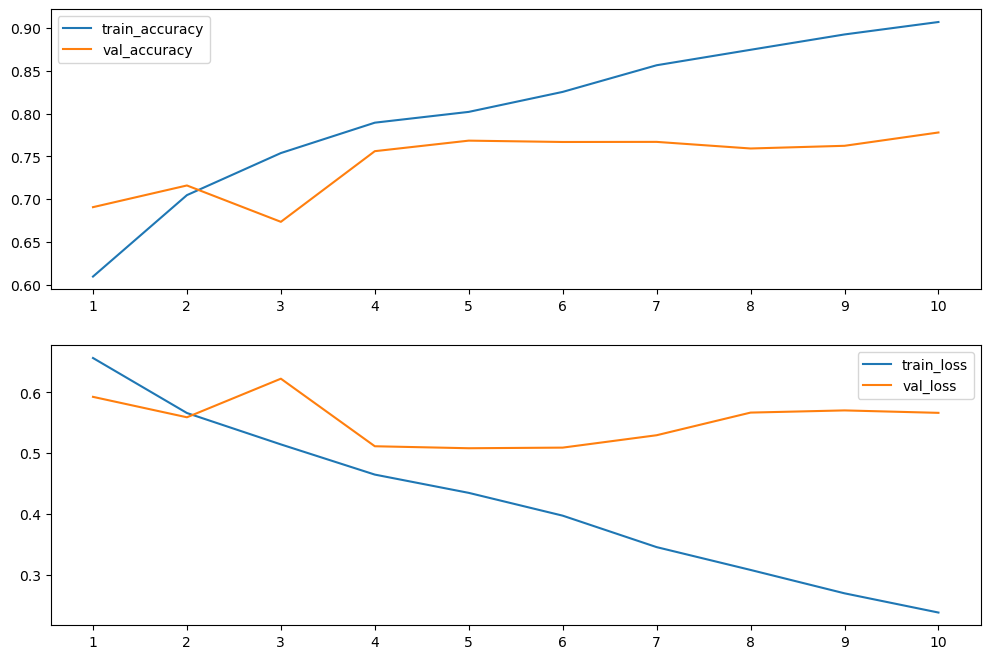

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

epochs = np.arange(1, n_epochs + 1)

ax[0].plot(epochs, history["accuracy"], label="train_accuracy")
ax[0].plot(epochs, history["val_accuracy"], label="val_accuracy")
ax[0].set_xticks(epochs)
ax[0].legend()
ax[1].plot(epochs, history["loss"], label="train_loss")
ax[1].plot(epochs, history["val_loss"], label="val_loss")
ax[1].set_xticks(epochs)
ax[1].legend()
plt.show()

In [43]:
np.median(history["accuracy"]).round(2)

0.81

**Answer**: `0.80` (nearest value)

## Question 4

What is the standard deviation of training loss for all the epochs for this model?

In [44]:
np.std(np.array(history["loss"])).round(2)

0.13

**Answer**: 
- TensorFlow: `0.091` (nearest value)
- PyTorch: `0.131` (a different solution)

# Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

- `RandomRotation(50)`
    - `rotation_range=50,`
- `RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1))`
    - `width_shift_range=0.1,`
    - `height_shift_range=0.1,`
    - `zoom_range=0.1,`
- `RandomHorizontalFlip()`
    - `horizontal_flip=True,`
- No fill_mode available in PyTorch
    - `fill_mode='nearest'`

In [45]:
image_size = 150
batch_size = 20

train_dir = "./data/train/"
test_dir  = "./data/test/"

### Transformations for training and testing data
train_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.RandomRotation(50),
    T.RandomAffine(
        0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
    ),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


val_transforms = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


### Dataset-objects for each part of the data
train_ds = datasets.ImageFolder(
    root=train_dir, 
    transform=train_transforms
)

val_ds = datasets.ImageFolder(
    root=test_dir, 
    transform=val_transforms
)

### Dataloader-objects for each dataset
train_loader = DataLoader(
    train_ds, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=True
)

Plotting some augmented images to see if it worked as intendet:

In [49]:
from torchvision.utils import make_grid

In [50]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    _, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = img.permute(1, 2, 0).numpy()

        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


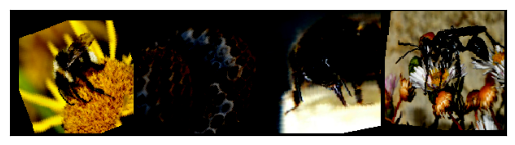

In [51]:
X = next(iter(train_loader))

imgs = [img for img in X[0][:4]]
grid = make_grid(imgs)
show(grid) # Images are normalized

### Question 5

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?


In [52]:
# save copy of old model, just in case
cnn_model_backup = type(cnn_model)()
cnn_model_backup.load_state_dict(cnn_model.state_dict())

<All keys matched successfully>

In [53]:
n_epochs = 10

history = train(
    cnn_model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    train_loader=train_loader,
    val_loader=test_loader
)

Epoch 1/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 19.84it/s]


loss: 0.5374 - accuracy: 0.7501 - val_loss: 0.4866 - val_accuracy: 0.7830


Epoch 2/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.09it/s]


loss: 0.4778 - accuracy: 0.7768 - val_loss: 0.5096 - val_accuracy: 0.7767


Epoch 3/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.94it/s]


loss: 0.4734 - accuracy: 0.7811 - val_loss: 0.4637 - val_accuracy: 0.7931


Epoch 4/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.78it/s]


loss: 0.4589 - accuracy: 0.7876 - val_loss: 0.4605 - val_accuracy: 0.7932


Epoch 5/10 [Validation]: 100%|██████████| 46/46 [00:01<00:00, 23.01it/s]


loss: 0.4518 - accuracy: 0.7966 - val_loss: 0.5324 - val_accuracy: 0.7534


Epoch 6/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 21.91it/s]


loss: 0.4417 - accuracy: 0.7993 - val_loss: 0.4542 - val_accuracy: 0.7988


Epoch 7/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.76it/s]


loss: 0.4431 - accuracy: 0.7987 - val_loss: 0.4624 - val_accuracy: 0.7825


Epoch 8/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.26it/s]


loss: 0.4402 - accuracy: 0.7970 - val_loss: 0.4505 - val_accuracy: 0.8041


Epoch 9/10 [Validation]: 100%|██████████| 46/46 [00:02<00:00, 22.91it/s]


loss: 0.4384 - accuracy: 0.7982 - val_loss: 0.4576 - val_accuracy: 0.7931


Epoch 10/10 [Validation]: 100%|██████████| 46/46 [00:01<00:00, 23.29it/s]

loss: 0.4323 - accuracy: 0.8001 - val_loss: 0.4422 - val_accuracy: 0.8117


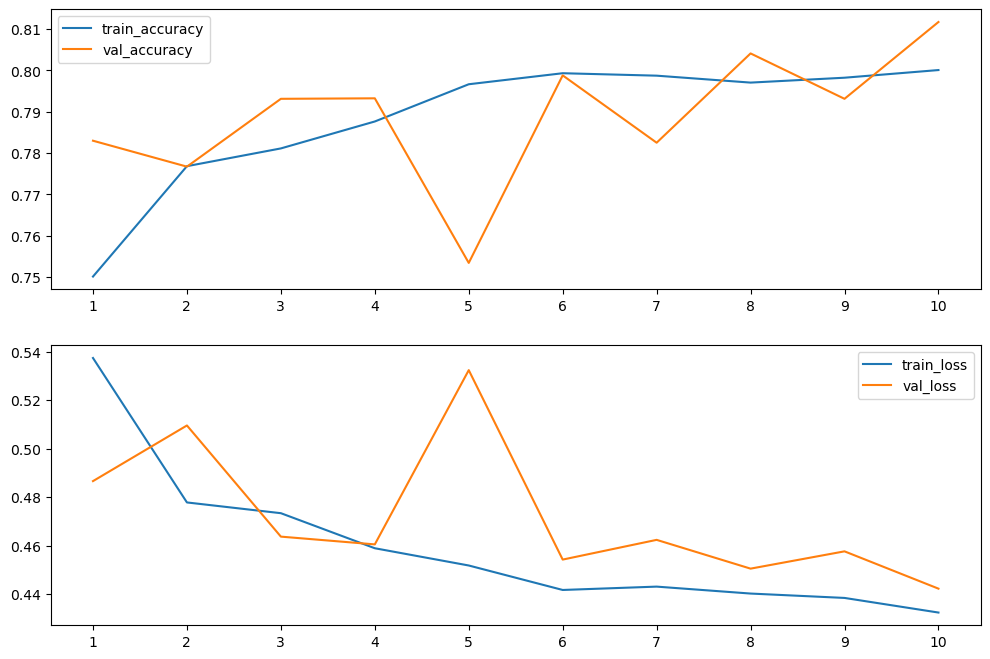

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

epochs = np.arange(1, n_epochs + 1)

ax[0].plot(epochs, history["accuracy"], label="train_accuracy")
ax[0].plot(epochs, history["val_accuracy"], label="val_accuracy")
ax[0].set_xticks(epochs)
ax[0].legend()
ax[1].plot(epochs, history["loss"], label="train_loss")
ax[1].plot(epochs, history["val_loss"], label="val_loss")
ax[1].set_xticks(epochs)
ax[1].legend()
plt.show()

Apparently the augmentation signifiantly reduced overfitting of the model. The downside is a reduced accuracy of the model, which could be raised by e.g. more training-epochs.

In [55]:
np.mean(history["val_loss"]).round(2)

0.47

**Answer**: `0.48` (nearest value)

### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?

In [56]:
np.mean(history["val_accuracy"][5:]).round(2)

0.8

**Answer**: `0.78` (nearest value)

# Testing the Model - Predictions

Get a random batch:

In [57]:
images, labels = next(iter(test_loader))

In [58]:
images.shape, labels.shape

(torch.Size([20, 3, 150, 150]), torch.Size([20]))

In [59]:
classes = {
    0: "bee",
    1: "wasp"
}

In [60]:
def inv_normalize(x, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """Unnormalize images from [-1, 1] to [0, 1]."""
    mean = torch.tensor(mean, dtype=torch.float32)
    std = torch.tensor(std, dtype=torch.float32)
    inv_mean = -mean / std; inv_std = 1.0 / std
    return T.Normalize(inv_mean.tolist(), inv_std.tolist())(x)

Plotting the image-batch:

(rows, cols) = (5, 4)


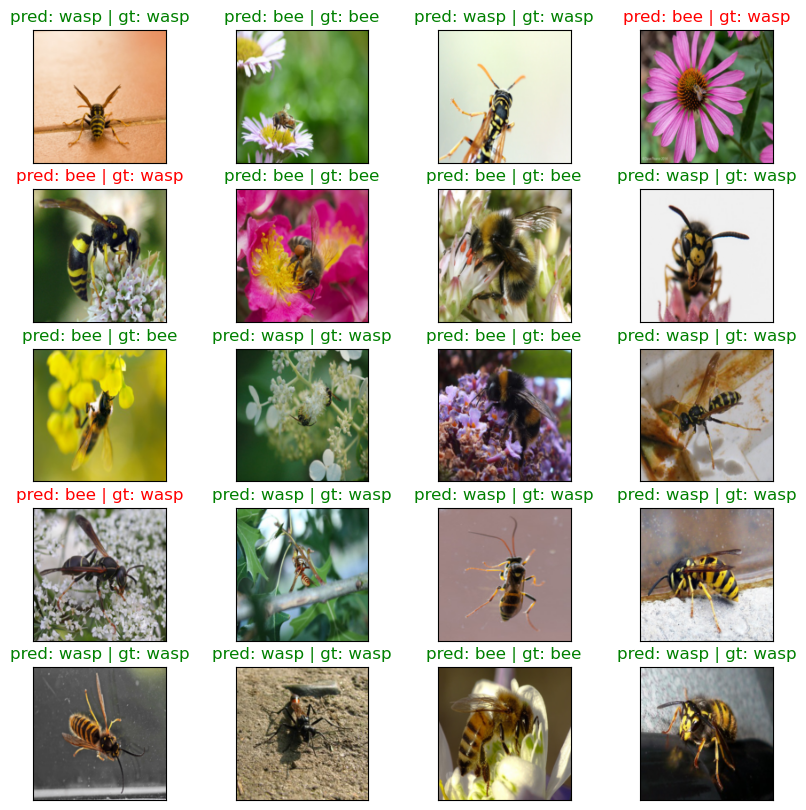

In [61]:
N = images.shape[0] # number of examples
ncols = 4
nrows = int(N / ncols)
print(f"(rows, cols) = ({nrows}, {ncols})")
assert ncols * nrows == N, "size missmatch"

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Getting data and pre-processing it
    img = images[i, ...]
    label = labels[i].item()
    pred = (cnn_model(img.unsqueeze(0).to(device)) >= 0.5).item()

    # Return image to original state
    img = inv_normalize(img).permute(1, 2, 0).numpy()

    # Plotting of results
    ax.imshow(img)
    txt_color = "green" if label == pred else "red"
    ax.set_title(f"pred: {classes[pred]} | gt: {classes[label]}", 
              color=txt_color)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### Save and Load a model

In [62]:
torch.save(cnn_model_backup, "bee-wasp-model-v1.pt")
torch.save(cnn_model, "bee-wasp-model-v2-augmented.pt")

In [63]:
model = torch.load("bee-wasp-model-v2-augmented.pt")
model

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=175232, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### Visualization of the model

For this `torchview` and `graphviz` are required:

In [64]:
!pip install -q graphviz torchview

In [65]:
from torchview import draw_graph

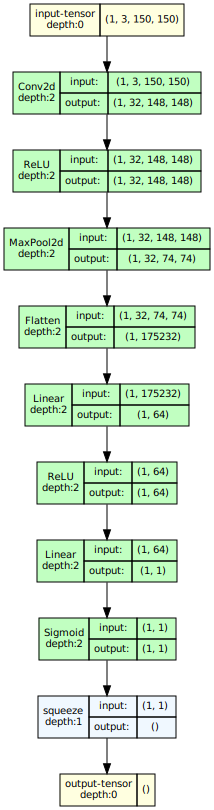

In [66]:
model_graph = draw_graph(model, input_size=(1, 3, 150, 150))
model_graph.visual_graph